# Business Case - 4Intelligence 

## Time Series Model

In [9]:
# installing libs and packages

!pip install statsmodels -q
!pip install sklearn -q
!pip install xgboost -q
!pip install pmdarima -q

In [10]:
# importing libs

import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.linear_model import LinearRegression ,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

In [11]:
# load dataset

data_path = 'E:\\Projects\\4intelligence_case\\data\\Bases_Final_ADS_Jun2021.xlsx'
df = pd.read_excel(data_path, sheet_name='dados')

In [12]:
# replace nan values
df = df.fillna(0)

In [13]:
# target feature

# setting date in index
df_time = df.set_index('data_tidy')
df_time = df_time.loc[df_time['ind_se']!=0]

time_series_ind_se = df_time['ind_se']
time_series_ind_se.index = pd.to_datetime(time_series_ind_se.index, errors='coerce')

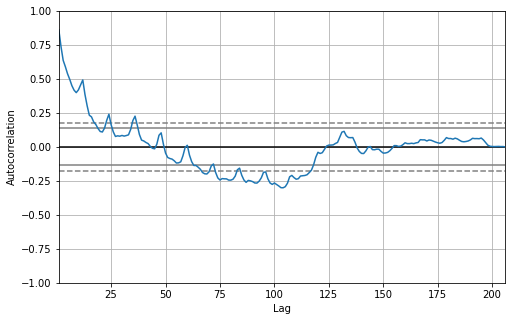

In [14]:
# autocorrelation plot in target feature
# checking randomness
rcParams['figure.figsize'] = 8, 5
autocorrelation_plot(time_series_ind_se)
plt.show()

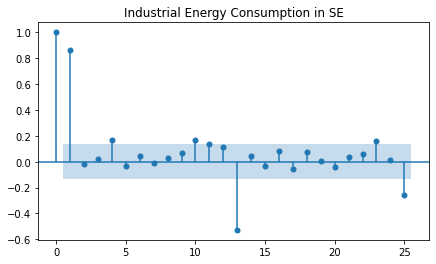

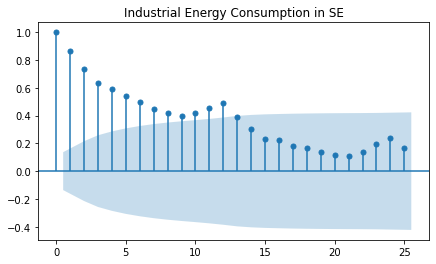

In [15]:
# autocorrelation and autocorrelation partial plots
# try to identify the best "p" and "q" to arima model params

rcParams['figure.figsize'] = 7, 4
plot_pacf(time_series_ind_se,lags=25,title='Industrial Energy Consumption in SE')
plot_acf(time_series_ind_se,lags=25,title='Industrial Energy Consumption in SE')
plt.show()

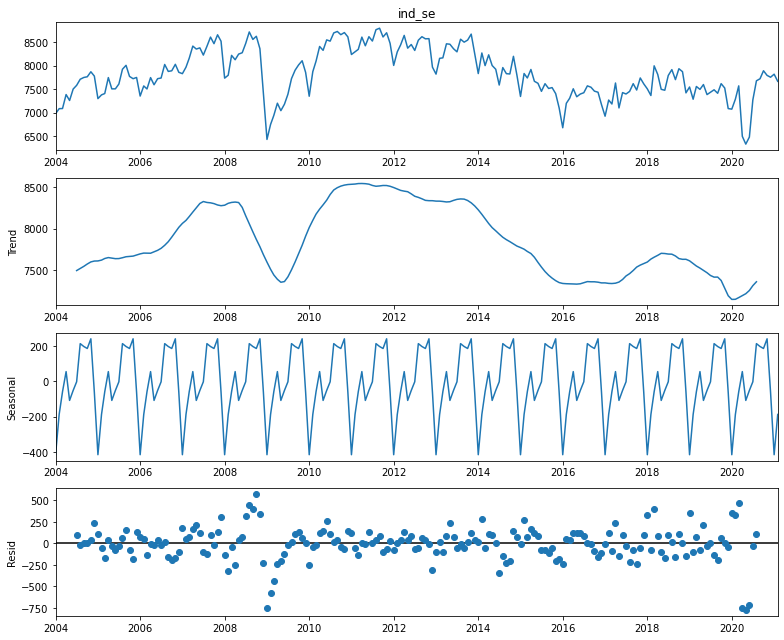

In [16]:
# decompose the energy in trend, seasonal and resids to know main trend and the frequent moviments
# statiscal analyze
# Industrial energy consumption in SE

rcParams['figure.figsize'] = 11, 9
decomposed_indse_energy = sm.tsa.seasonal_decompose(time_series_ind_se) # The frequncy is annual
figure = decomposed_indse_energy.plot()
plt.show()

## Feature Engineering

In [17]:
# change datetime to date
df['data_tidy'] = df['data_tidy'].apply(lambda x: x.date())

In [18]:
# creating year, month features

df['ano'] = df['data_tidy'].apply(lambda x: x.year)
df['mes'] = df['data_tidy'].apply(lambda x: x.month)

In [19]:
# creating new features

# total energy consumed by business category
df['com_total'] = df['com_co'] + df['com_n'] + df['com_ne'] + df['com_s'] + df['com_se']

# total energy consumed by industrial category
df['ind_total'] = df['ind_co'] + df['ind_n'] + df['ind_ne'] + df['ind_s'] + df['ind_se']

# total energy consumed by residential category
df['res_total'] = df['res_co'] + df['res_n'] + df['res_ne'] + df['res_s'] + df['res_se']

# total energy consumed
df['total'] = df['res_total'] + df['ind_total'] + df['com_total']

In [20]:
# creating new features about each region
# consumption total by region

# SE
df['se_total'] = df['com_se'] + df['ind_se'] + df['com_se']
# S
df['s_total'] = df['com_s'] + df['ind_s'] + df['com_s']
# NE
df['ne_total'] = df['com_ne'] + df['ind_ne'] + df['com_ne']
# N
df['n_total'] = df['com_n'] + df['ind_n'] + df['com_n']
# CO
df['co_total'] = df['com_co'] + df['ind_co'] + df['com_co']

In [21]:
# new features about temperature

# max tempearature in Brazil
df['max_temp'] = df[['temp_max_n','temp_max_ne','temp_max_co','temp_max_se','temp_max_s']].max(axis =1)
# min tempearature in Brazil
df['min_temp'] = df[['temp_max_n','temp_max_ne','temp_max_co','temp_max_se','temp_max_s']].min(axis =1)
# delta - the difference
df['delta'] = df['max_temp'] - df['min_temp']
# the mean -min-max
df['media_temp'] = (df['max_temp'] + df['min_temp'])/2

In [22]:
# split train-validation dataset

df_train = df.loc[df['data_tidy'] <= date(2021,2,1)]
df_val = df.loc[df['data_tidy'] > date(2021,2,1)]

## Feature Selection

In [23]:
# creating correlation matrix
mc = df_train.corr(method = 'spearman')

In [24]:
# strongests correlations between industrial energy consumption SE
mc['ind_se'].sort_values(ascending=False)

ind_se         1.000000
ind_total      0.866199
ind_ne         0.776863
pim_se         0.776097
pim_s          0.649239
pim_ne         0.400772
pmc_a_co       0.315525
pim_n          0.295265
mes            0.280137
se_total       0.242482
pmc_a_se       0.237138
pmc_r_co       0.228774
pmc_a_ne       0.225124
ne_total       0.217422
temp_max_n     0.197419
max_temp       0.196812
delta          0.195923
pmc_a_n        0.138559
pim_co         0.131332
ind_s          0.116625
pmc_r_ne       0.116338
pmc_a_s        0.099269
temp_max_co    0.053035
pmc_r_n        0.052566
ind_n          0.037923
pmc_r_se       0.027487
du            -0.002781
temp_max_ne   -0.008807
total         -0.010770
pop_ocup_br   -0.059574
s_total       -0.071501
pmc_r_s       -0.083293
ind_co        -0.091578
n_total       -0.110666
temp_max_se   -0.110816
temp_min_n    -0.123244
com_se        -0.124850
temp_min_ne   -0.127405
co_total      -0.137572
media_temp    -0.148875
com_s         -0.163382
res_se        -0

In [25]:
# spliting features and target

train_features = df_train.drop(['ind_se','data_tidy'], axis =1)

label = df_train[['ind_se']]

In [26]:
# scalling features

scaler = StandardScaler()
features_sc = scaler.fit_transform(train_features)

In [27]:
# feature selection the goal is to reduce the dimensionality of the data
estimator = SVR(kernel='linear')
selector = RFE(estimator, n_features_to_select=20)

selector = selector.fit(features_sc, label)

cols = selector.get_support(indices=(True))
selector.ranking_

array([16,  1,  1, 27, 21, 18, 37,  1,  1,  3,  1,  1,  6, 36,  1, 39,  1,
        1,  1, 13, 33, 11,  1,  8, 32,  7, 26,  1,  4, 23, 35, 20,  1, 17,
       31, 19, 25,  1,  2, 29, 22, 38,  1,  1,  1, 14,  1,  9,  5,  1, 15,
        1, 10, 12, 30, 28, 24, 34])

In [28]:
# features selection by SVR estimator
train_features = df_train.iloc[:,cols]
train_features.columns

Index(['com_co', 'com_n', 'ind_n', 'ind_ne', 'ind_se', 'res_co', 'res_s',
       'renda_r', 'pop_ocup_br', 'massa_r', 'temp_min_co', 'temp_min_n',
       'temp_min_ne', 'temp_min_s', 'temp_min_se', 'pmc_r_se', 'pim_se', 'mes',
       'res_total', 'se_total'],
      dtype='object')

In [29]:
# selecting features and target

train_features = df_train[['pim_se','pim_s','pim_ne','massa_r','renda_r',
                            'pop_ocup_br','pmc_r_se','mes','temp_min_se',
                            'mes','pmc_r_s','media_temp','pmc_a_co','ano']]

label = df_train[['ind_se']]

In [30]:
# scalling features

scaler = StandardScaler()
features = scaler.fit_transform(train_features)

In [31]:
# spliting test dataset


train_features, test_features, train_labels, test_labels = train_test_split(features , label, 
                                                                            test_size = 0.25, 
                                                                            random_state = 0)

## Model 1: Linear Regression

In [32]:
# model 1: Linear Regression

model1 = LinearRegression()
model1.fit(train_features, train_labels)

LinearRegression()

In [33]:
# predictions

predictions = model1.predict(test_features)

In [34]:
# evaluate the model 1

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Linear Regression MAE: ', mae)
print('Linear Regression MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


Linear Regression MAE:  223.7698255866803
Linear Regression MSE:  75216.70040673163
Coefficient of determination: 0.65


## Model 2: ElasticNet

In [35]:
# model 2: ElasticNet

model2 = ElasticNet()

# test all hyperparams below
param_grid = [{'l1_ratio':[0.25, 0.5, 0.75, 1],
               'max_iter':[500, 750, 1000, 2000, 5000]}]

# exhaustive search for best params
GS = GridSearchCV(model2 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'l1_ratio': 1, 'max_iter': 5000}


In [36]:
# model 2 with best params

model2 = ElasticNet(l1_ratio = GS.best_params_['l1_ratio'] , 
                    max_iter = GS.best_params_['max_iter'])

model2.fit(train_features , train_labels)
predictions = model2.predict(test_features)

In [37]:
# evaluate the model 2

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('ElasticNet MAE: ', mae)
print('ElasticNet MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


ElasticNet MAE:  229.78360684217353
ElasticNet MSE:  80869.87243265883
Coefficient of determination: 0.63


## Model 3: Random Forest

In [38]:
# model 3: Random Forest

model3 = RandomForestRegressor()

# test all hyperparams below
param_grid = [{'n_estimators':[35,40,45,50,55,60,70,80,90,100],
               'max_depth':[3,5,6,7,8,9,10,11,12,15,20]}]

# exhaustive search for best params
GS = GridSearchCV(model3 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'max_depth': 15, 'n_estimators': 50}


In [39]:
# model 3 with best params

model3 = RandomForestRegressor(n_estimators = GS.best_params_['n_estimators'] , 
                            max_depth = GS.best_params_['max_depth'])

model3.fit(train_features , train_labels)
predictions = model3.predict(test_features)

In [40]:
# evaluate the model 3

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Random Forest MAE: ', mae)
print('Random Forest MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))


Random Forest MAE:  181.25057262692306
Random Forest MSE:  63405.47274180277
Coefficient of determination: 0.71


## Model 4: Gradient Descent

In [41]:
# model 4: Gradient descent

model4 = XGBRegressor()

# test all hyperparams below
param_grid = [{'max_depth':[4,5,6,7,8,9,10,11,12,13],
               'n_estimators':[100,150,180,200],
               'objective':['reg:squarederror'],
               'eval_metric':['mae'],
               'booster':['gbtree'],
               'learning_rate':[0.5,0.7,0.9]}]

# exhaustive search for best params
GS = GridSearchCV(model4 , param_grid , scoring= 'neg_mean_squared_error' , error_score= 'raise', cv=3)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'booster': 'gbtree', 'eval_metric': 'mae', 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 150, 'objective': 'reg:squarederror'}


In [42]:
# model 4 with best params

model4 = XGBRegressor(n_estimators = GS.best_params_['n_estimators'] , 
                    max_depth = GS.best_params_['max_depth'],
                    objective = GS.best_params_['objective'],
                    eval_metric = GS.best_params_['eval_metric'],
                    booster = GS.best_params_['booster'],
                    learning_rate = GS.best_params_['learning_rate'])

model4.fit(train_features , train_labels)
predictions = model4.predict(test_features)

In [43]:
# evaluate the model 4

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Gradient Descent MAE: ', mae)
print('Gradient Descent MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))

Gradient Descent MAE:  149.73996777944714
Gradient Descent MSE:  34292.115235707635
Coefficient of determination: 0.84


## Model 5: Support Vector Machine

In [44]:
# model 5: Support Vector Machine

model5 = SVR()

param_grid = [{'kernel':['linear','poly','rbf','sigmoid'],
               'degree':[1,2,3,4,5,6],
               'epsilon':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
               'C':[1,2,3,4,5,6,7,8,9]}]

# exhaustive search for best params
GS = GridSearchCV(model5 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=5)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'C': 9, 'degree': 1, 'epsilon': 0.9, 'kernel': 'linear'}


In [45]:
# model 5 with best params

model5 = SVR(kernel= GS.best_params_['kernel'],
            degree= GS.best_params_['degree'],
            epsilon= GS.best_params_['epsilon'],
            C= GS.best_params_['C'])

model5.fit(train_features , train_labels)
predictions = model5.predict(test_features)

In [46]:
# evaluate the model 5

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('SVR MAE: ', mae)
print('SVR MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))

SVR MAE:  233.26096580364626
SVR MSE:  82624.6960438402
Coefficient of determination: 0.62


## Model 6: Neural Networks

In [47]:
# model 6: Neural Netwoks

model6 = MLPRegressor()

param_grid = [{'activation':['relu'],'solver':['lbfgs'],'alpha':[0.01],
               'hidden_layer_sizes':[(100,100),(50),(50,50,50)],
               'max_iter':[250,500],
               'learning_rate':['constant', 'invscaling', 'adaptive'],
               'tol':[0.01]}]

# exhaustive search for best params
GS = GridSearchCV(model6 , param_grid , scoring= 'neg_mean_absolute_error' , error_score= 'raise', cv=3)
GS.fit(train_features, train_labels)
print(GS.best_params_)

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 250, 'solver': 'lbfgs', 'tol': 0.01}


In [48]:
# model 6 with best params

model6 = MLPRegressor(activation= GS.best_params_['activation'],
                        alpha= GS.best_params_['alpha'],
                        hidden_layer_sizes= GS.best_params_['hidden_layer_sizes'],
                        learning_rate= GS.best_params_['learning_rate'],
                        max_iter= GS.best_params_['max_iter'],
                        solver= GS.best_params_['solver'],
                        tol= GS.best_params_['tol'])

model6.fit(train_features , train_labels)
predictions = model5.predict(test_features)

In [49]:
# evaluate the model 6

mae = mean_absolute_error(test_labels , predictions)
mse = mean_squared_error(test_labels , predictions)
print('Neural Networks MAE: ', mae)
print('Neural Networks MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(test_labels , predictions))

Neural Networks MAE:  233.26096580364626
Neural Networks MSE:  82624.6960438402
Coefficient of determination: 0.62


## Model 7: ARIMA

In [50]:
# now, test a specific time series model: ARIMA
# split train-test-validation dataset

df_train = df.loc[df['data_tidy'] <= date(2018,7,1)]
df_test = df.loc[(df['data_tidy'] > date(2018,7,1))&(df['data_tidy'] <= date(2021,2,1))]
df_val = df.loc[df['data_tidy'] > date(2021,2,1)]

In [51]:
# setting date in index
df_arima = df.set_index('data_tidy')
df_arima_train = df_train.set_index('data_tidy')
df_arima_test = df_test.set_index('data_tidy')
df_arima_val = df_val.set_index('data_tidy')

time_series_arima = df_arima['ind_se']
time_series_arimatr = df_arima_train['ind_se']
time_series_arimats = df_arima_test['ind_se']
time_series_arimavl = df_arima_val['ind_se']

time_series_arima.index = pd.to_datetime(time_series_arima.index, errors='coerce')
time_series_arimatr.index = pd.to_datetime(time_series_arimatr.index, errors='coerce')
time_series_arimats.index = pd.to_datetime(time_series_arimats.index, errors='coerce')
time_series_arimavl.index = pd.to_datetime(time_series_arimavl.index, errors='coerce')

In [52]:
# searching best arima model params

model7 = auto_arima(time_series_arima , start_p=1, start_q=1, max_p=12, max_q=12, start_P=0, 
                    seasonal=True, trace = True, suppress_warnings=True, error_action='ignore',
                    stepwise=True, d=1, D=1 , m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3483.380, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3385.259, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3368.839, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3485.183, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3369.834, Time=1.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3369.879, Time=1.61 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3385.261, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.36 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3366.866, Time=0.22 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3367.847, Time=0.63 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=3367.893, Time=1.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3383.393, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=3369.089, Time=2.96 sec
 ARIMA(1,1,0)(0,1,1)[12]     

In [53]:
# training in train dataset
model7.fit(time_series_arimatr)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [54]:
# forecast: 2018-8-1 to 2021-2-1
predictions = model7.predict(n_periods= 31)

<AxesSubplot:title={'center':'Original x Predicted'}, xlabel='data_tidy', ylabel='ind_se'>

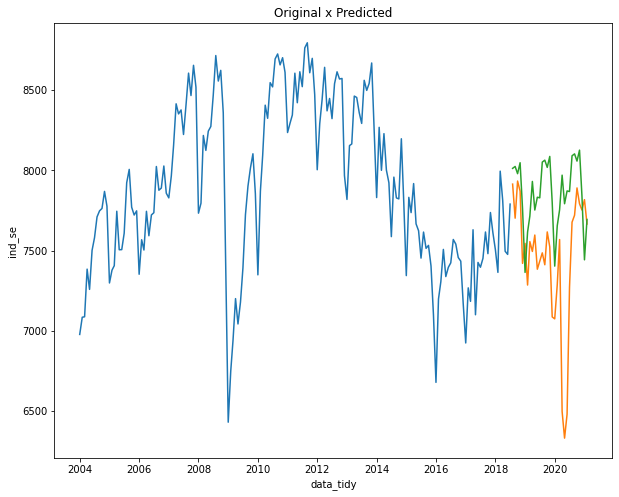

In [55]:
# plot real and predict values

rcParams['figure.figsize'] = 10, 8
sns.lineplot(x= df_train['data_tidy'] , y= df_train['ind_se'])
sns.lineplot(x= df_test['data_tidy'] , y= df_test['ind_se']).set_title('Original x Predicted')
sns.lineplot(x= df_test['data_tidy'] , y= predictions)

In [56]:
# evaluate the model 7

mae = mean_absolute_error(time_series_arimats , predictions)
mse = mean_squared_error(time_series_arimats , predictions)
print('ARIMA MAE: ', mae)
print('ARIMA MSE: ', mse)
print('Coefficient of determination: %.2f'
      % r2_score(time_series_arimats , predictions))


ARIMA MAE:  438.22683683159033
ARIMA MSE:  329775.74357960344
Coefficient of determination: -1.06


## Conclusions

In [57]:
# selected model: Gradient descent in test dataset (Model 4)

# selecting features and target

test_features = df_test[['pim_se','pim_s','pim_ne','massa_r','renda_r',
                            'pop_ocup_br','pmc_r_se','mes','temp_min_se',
                            'mes','pmc_r_s','media_temp','pmc_a_co','ano']]

label = df_test[['ind_se']]

In [58]:
# scalling features

scaler = StandardScaler()
features = scaler.fit_transform(test_features)

In [59]:
# predictions using XGBoost

predictions = model4.predict(features)

<AxesSubplot:title={'center':'Original x Predicted'}, xlabel='data_tidy', ylabel='ind_se'>

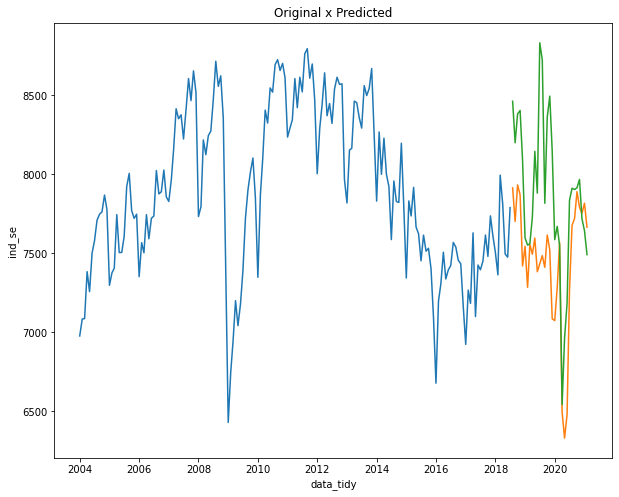

In [60]:
# plot real and predict values of XGBoost model

rcParams['figure.figsize'] = 10, 8
sns.lineplot(x= df_train['data_tidy'] , y= df_train['ind_se'])
sns.lineplot(x= df_test['data_tidy'] , y= df_test['ind_se']).set_title('Original x Predicted')
sns.lineplot(x= df_test['data_tidy'] , y= predictions)
plt.grid()

## Predict New Values: 2021-03-01 to 2022-12-01

In [61]:
# selecting features and target

val_features = df_val[['pim_se','pim_s','pim_ne','massa_r','renda_r',
                            'pop_ocup_br','pmc_r_se','mes','temp_min_se',
                            'mes','pmc_r_s','media_temp','pmc_a_co','ano']]

label = df_val[['ind_se']]

In [62]:
# scalling features

scaler = StandardScaler()
val_features = scaler.fit_transform(val_features)

In [63]:
# predictions in validation dataset: 2021-03-01 to 2022-12-01
predictions = model4.predict(val_features)

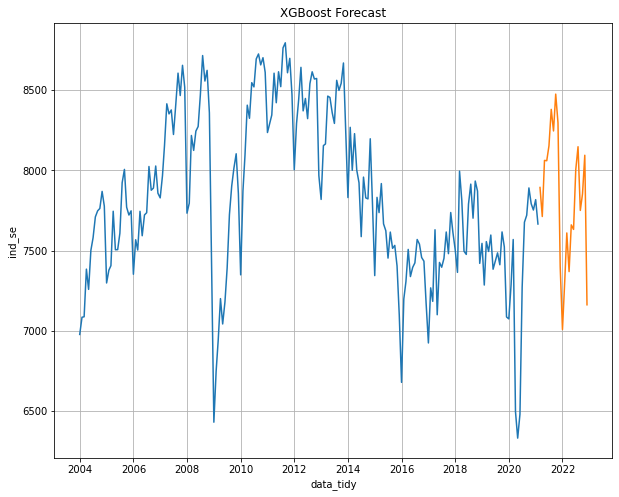

In [72]:
# plot real and predict values of XGBoost model

df_plot = df.loc[df['data_tidy'] <= date(2021,2,1)]
rcParams['figure.figsize'] = 10, 8
sns.lineplot(x= df_plot['data_tidy'] , y= df_plot['ind_se']).set_title('XGBoost Forecast')
sns.lineplot(x= df_val['data_tidy'] , y= predictions)
plt.grid()